# Semantic Segmentation Lab
In this lab, you will build a deep learning network that locates a particular human target within an image.  The premise is that a quadcopter (simulated) is searching for a target, and then will follow the target once found.  It's not enough to simply say the target is present in the image in this case, but rather to know *where* in the image the target is, so that the copter can adjust its direction in order to follow.

Consequently, an image classification network is not enough to solve the problem. Intead, a semantic segmentation network is needed so that the target can be specifically located within the image.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [4]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools


## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will intoduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [5]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [6]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [7]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [109]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [156]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder1 = encoder_block(inputs, 20, [2,2])
    encoder2 = encoder_block(encoder1, 30, [2,2])
    encoder3  = encoder_block(encoder2, 40, [2,2])
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv1 = conv2d_batchnorm(encoder3, 50, kernel_size = 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    decoder1 = decoder_block(conv1, encoder2, 40)
    decoder2 = decoder_block(decoder1, encoder1, 30)
    x = decoder_block(decoder2, inputs, 20)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [157]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [159]:
learning_rate = 0.002
batch_size = 250
num_epochs = 100
steps_per_epoch = 30
validation_steps = 40
workers = 2

Epoch 1/100
29/30 [============================>.] - ETA: 2s - loss: 0.9750

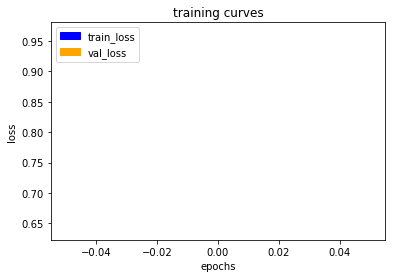

30/30 [==============================] - 102s - loss: 0.9638 - val_loss: 0.6392
Epoch 2/100
29/30 [============================>.] - ETA: 1s - loss: 0.3015

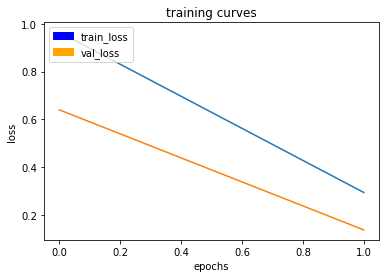

30/30 [==============================] - 93s - loss: 0.2950 - val_loss: 0.1365
Epoch 3/100
29/30 [============================>.] - ETA: 1s - loss: 0.0833

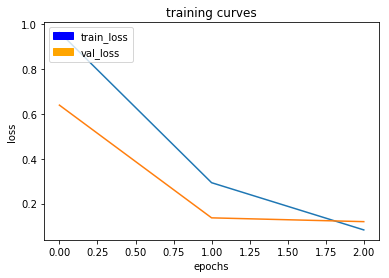

30/30 [==============================] - 92s - loss: 0.0826 - val_loss: 0.1196
Epoch 4/100
29/30 [============================>.] - ETA: 1s - loss: 0.0608

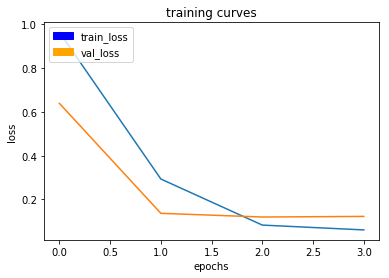

30/30 [==============================] - 93s - loss: 0.0606 - val_loss: 0.1224
Epoch 5/100
29/30 [============================>.] - ETA: 1s - loss: 0.0536

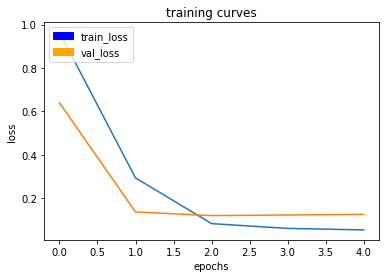

30/30 [==============================] - 94s - loss: 0.0536 - val_loss: 0.1252
Epoch 6/100
29/30 [============================>.] - ETA: 1s - loss: 0.0472

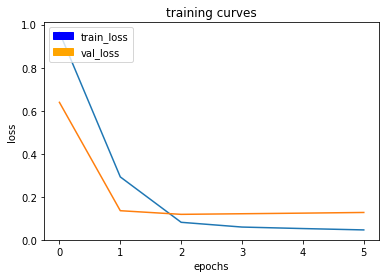

30/30 [==============================] - 92s - loss: 0.0474 - val_loss: 0.1283
Epoch 7/100
29/30 [============================>.] - ETA: 1s - loss: 0.0445

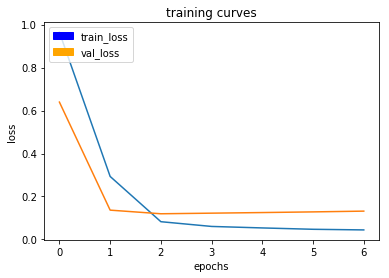

30/30 [==============================] - 92s - loss: 0.0444 - val_loss: 0.1318
Epoch 8/100
29/30 [============================>.] - ETA: 1s - loss: 0.0411

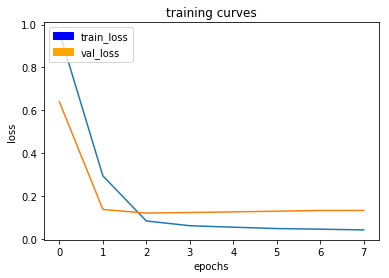

30/30 [==============================] - 93s - loss: 0.0410 - val_loss: 0.1320
Epoch 9/100
29/30 [============================>.] - ETA: 1s - loss: 0.0391

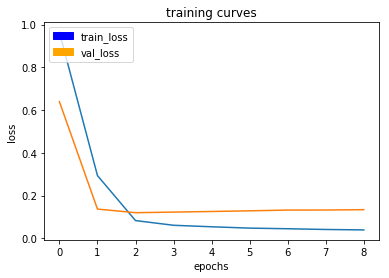

30/30 [==============================] - 95s - loss: 0.0389 - val_loss: 0.1337
Epoch 10/100
29/30 [============================>.] - ETA: 1s - loss: 0.0367

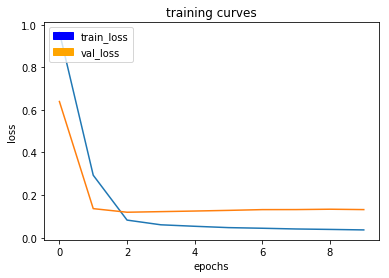

30/30 [==============================] - 92s - loss: 0.0366 - val_loss: 0.1319
Epoch 11/100
29/30 [============================>.] - ETA: 1s - loss: 0.0355

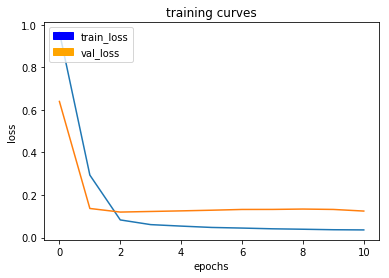

30/30 [==============================] - 93s - loss: 0.0357 - val_loss: 0.1243
Epoch 12/100
29/30 [============================>.] - ETA: 1s - loss: 0.0338

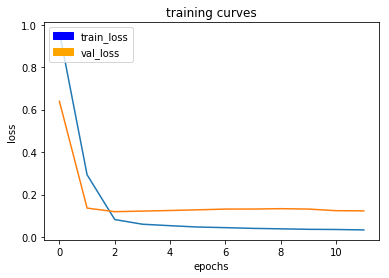

30/30 [==============================] - 93s - loss: 0.0340 - val_loss: 0.1235
Epoch 13/100
29/30 [============================>.] - ETA: 1s - loss: 0.0330

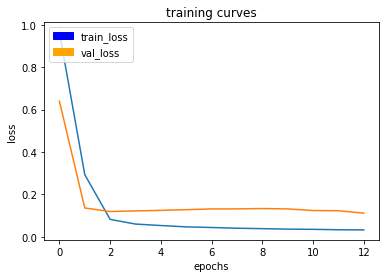

30/30 [==============================] - 95s - loss: 0.0330 - val_loss: 0.1121
Epoch 14/100
29/30 [============================>.] - ETA: 1s - loss: 0.0322

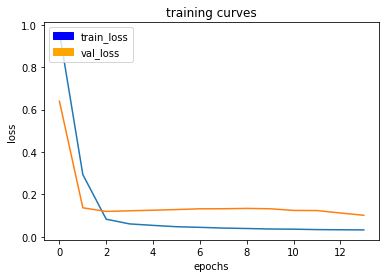

30/30 [==============================] - 95s - loss: 0.0322 - val_loss: 0.1012
Epoch 15/100
29/30 [============================>.] - ETA: 1s - loss: 0.0318

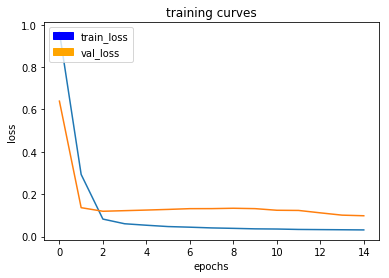

30/30 [==============================] - 93s - loss: 0.0317 - val_loss: 0.0983
Epoch 16/100
29/30 [============================>.] - ETA: 1s - loss: 0.0304

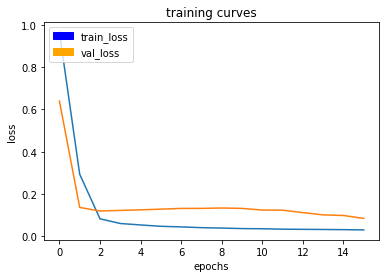

30/30 [==============================] - 93s - loss: 0.0303 - val_loss: 0.0847
Epoch 17/100
29/30 [============================>.] - ETA: 1s - loss: 0.0313

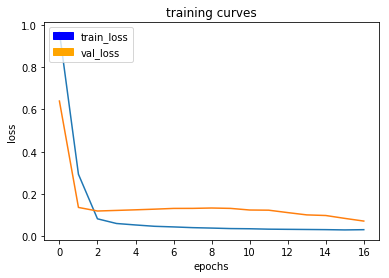

30/30 [==============================] - 94s - loss: 0.0313 - val_loss: 0.0720
Epoch 18/100
29/30 [============================>.] - ETA: 1s - loss: 0.0300

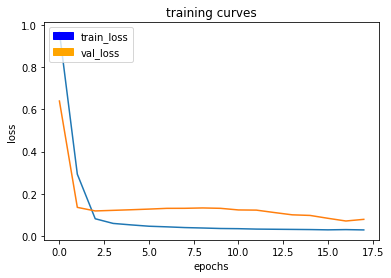

30/30 [==============================] - 95s - loss: 0.0298 - val_loss: 0.0798
Epoch 19/100
29/30 [============================>.] - ETA: 1s - loss: 0.0293

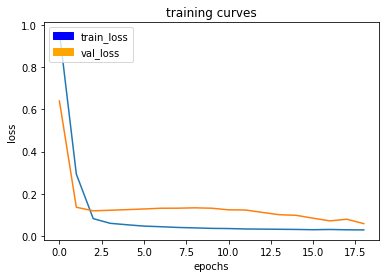

30/30 [==============================] - 93s - loss: 0.0293 - val_loss: 0.0590
Epoch 20/100
29/30 [============================>.] - ETA: 1s - loss: 0.0289

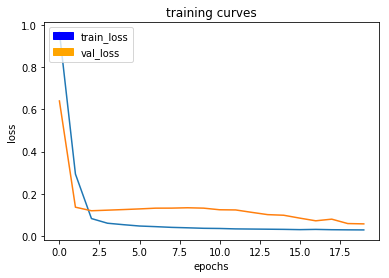

30/30 [==============================] - 92s - loss: 0.0289 - val_loss: 0.0575
Epoch 21/100
29/30 [============================>.] - ETA: 1s - loss: 0.0278

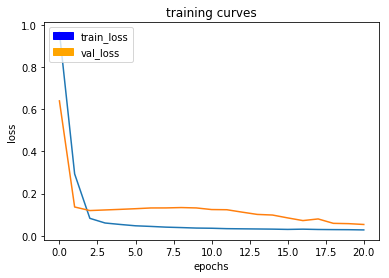

30/30 [==============================] - 93s - loss: 0.0278 - val_loss: 0.0536
Epoch 22/100
29/30 [============================>.] - ETA: 1s - loss: 0.0280

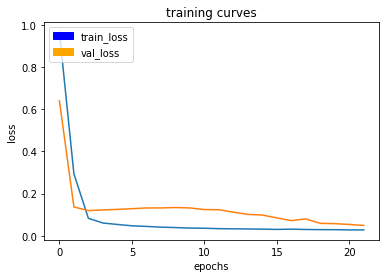

30/30 [==============================] - 95s - loss: 0.0279 - val_loss: 0.0490
Epoch 23/100
29/30 [============================>.] - ETA: 1s - loss: 0.0272

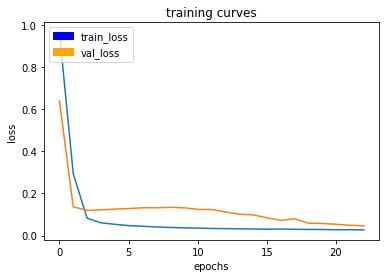

30/30 [==============================] - 92s - loss: 0.0271 - val_loss: 0.0461
Epoch 24/100
29/30 [============================>.] - ETA: 1s - loss: 0.0273

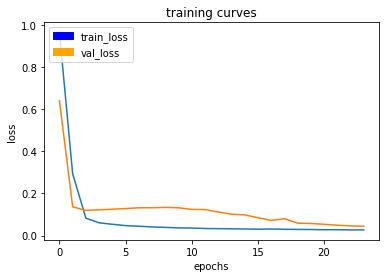

30/30 [==============================] - 94s - loss: 0.0272 - val_loss: 0.0447
Epoch 25/100
29/30 [============================>.] - ETA: 1s - loss: 0.0273

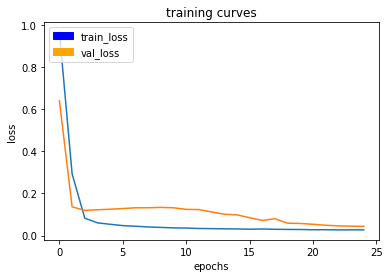

30/30 [==============================] - 94s - loss: 0.0272 - val_loss: 0.0439
Epoch 26/100
29/30 [============================>.] - ETA: 1s - loss: 0.0265

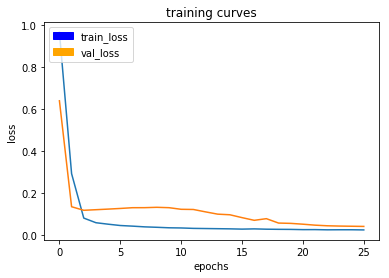

30/30 [==============================] - 95s - loss: 0.0264 - val_loss: 0.0430
Epoch 27/100
29/30 [============================>.] - ETA: 1s - loss: 0.0256

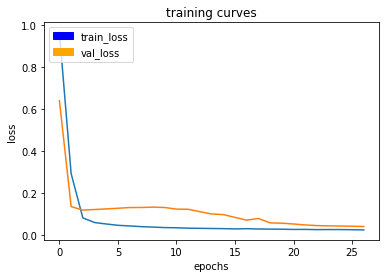

30/30 [==============================] - 93s - loss: 0.0256 - val_loss: 0.0417
Epoch 28/100
29/30 [============================>.] - ETA: 1s - loss: 0.0261

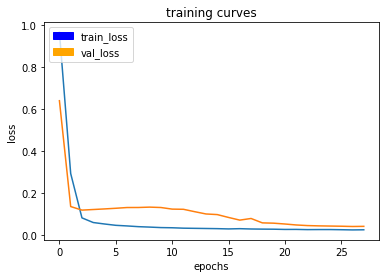

30/30 [==============================] - 94s - loss: 0.0261 - val_loss: 0.0424
Epoch 29/100
29/30 [============================>.] - ETA: 1s - loss: 0.0254

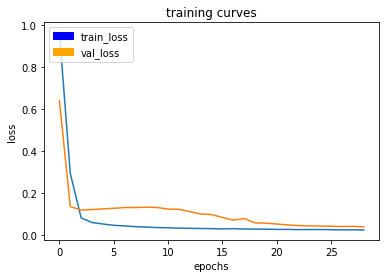

30/30 [==============================] - 94s - loss: 0.0255 - val_loss: 0.0401
Epoch 30/100
29/30 [============================>.] - ETA: 1s - loss: 0.0257

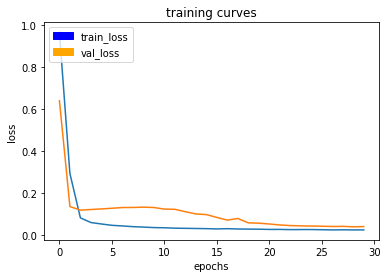

30/30 [==============================] - 95s - loss: 0.0256 - val_loss: 0.0413
Epoch 31/100
29/30 [============================>.] - ETA: 1s - loss: 0.0246

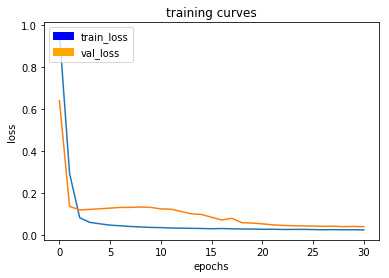

30/30 [==============================] - 93s - loss: 0.0248 - val_loss: 0.0403
Epoch 32/100
29/30 [============================>.] - ETA: 1s - loss: 0.0248

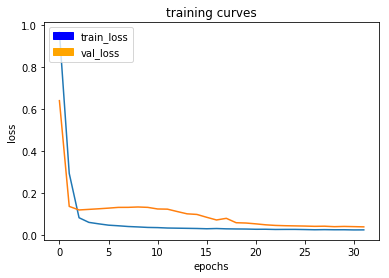

30/30 [==============================] - 94s - loss: 0.0248 - val_loss: 0.0393
Epoch 33/100
29/30 [============================>.] - ETA: 1s - loss: 0.0247

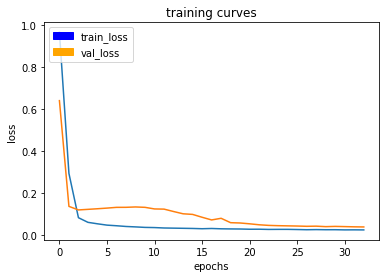

30/30 [==============================] - 93s - loss: 0.0246 - val_loss: 0.0387
Epoch 34/100
29/30 [============================>.] - ETA: 1s - loss: 0.0242

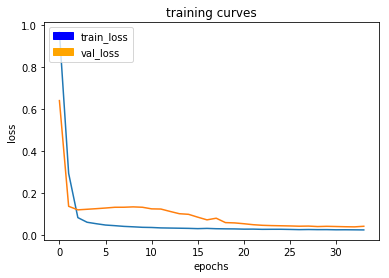

30/30 [==============================] - 92s - loss: 0.0242 - val_loss: 0.0415
Epoch 35/100
29/30 [============================>.] - ETA: 1s - loss: 0.0241

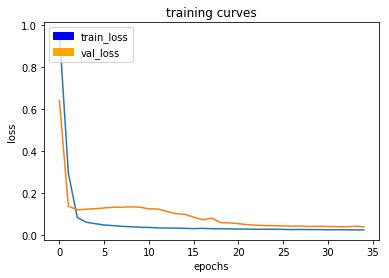

30/30 [==============================] - 94s - loss: 0.0240 - val_loss: 0.0387
Epoch 36/100
29/30 [============================>.] - ETA: 1s - loss: 0.0238

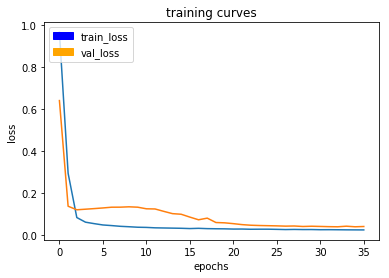

30/30 [==============================] - 95s - loss: 0.0239 - val_loss: 0.0400
Epoch 37/100
29/30 [============================>.] - ETA: 1s - loss: 0.0242

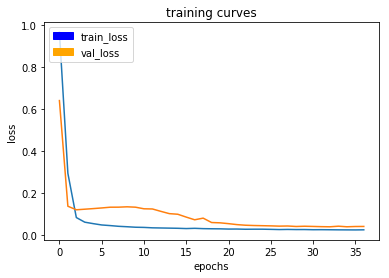

30/30 [==============================] - 93s - loss: 0.0242 - val_loss: 0.0403
Epoch 38/100
29/30 [============================>.] - ETA: 1s - loss: 0.0237

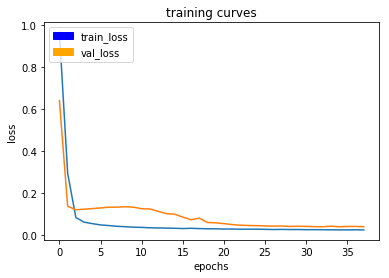

30/30 [==============================] - 92s - loss: 0.0236 - val_loss: 0.0387
Epoch 39/100
29/30 [============================>.] - ETA: 1s - loss: 0.0241

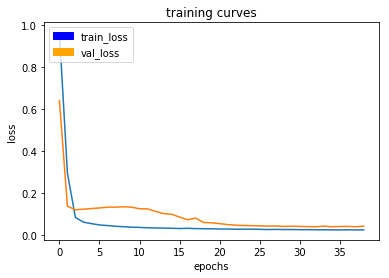

30/30 [==============================] - 94s - loss: 0.0241 - val_loss: 0.0416
Epoch 40/100
29/30 [============================>.] - ETA: 1s - loss: 0.0235

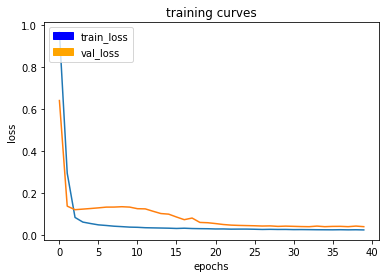

30/30 [==============================] - 93s - loss: 0.0234 - val_loss: 0.0387
Epoch 41/100
29/30 [============================>.] - ETA: 1s - loss: 0.0233

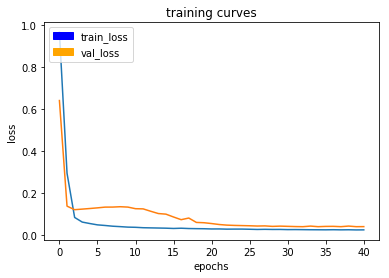

30/30 [==============================] - 94s - loss: 0.0234 - val_loss: 0.0390
Epoch 42/100
29/30 [============================>.] - ETA: 1s - loss: 0.0229

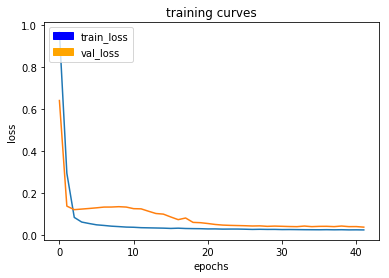

30/30 [==============================] - 94s - loss: 0.0230 - val_loss: 0.0363
Epoch 43/100
29/30 [============================>.] - ETA: 1s - loss: 0.0231

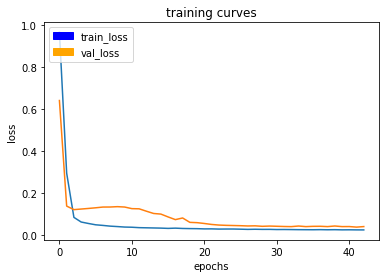

30/30 [==============================] - 95s - loss: 0.0231 - val_loss: 0.0388
Epoch 44/100
29/30 [============================>.] - ETA: 1s - loss: 0.0229

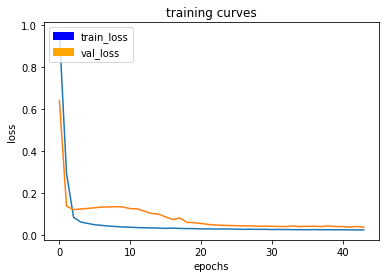

30/30 [==============================] - 93s - loss: 0.0229 - val_loss: 0.0360
Epoch 45/100
29/30 [============================>.] - ETA: 1s - loss: 0.0226

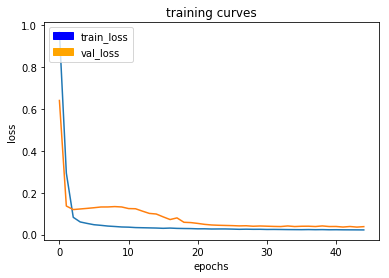

30/30 [==============================] - 94s - loss: 0.0226 - val_loss: 0.0382
Epoch 46/100
29/30 [============================>.] - ETA: 1s - loss: 0.0229

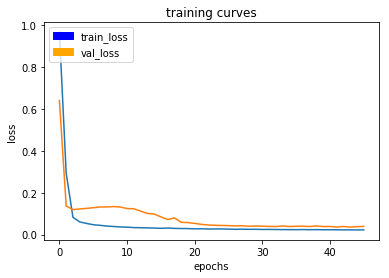

30/30 [==============================] - 92s - loss: 0.0227 - val_loss: 0.0392
Epoch 47/100
29/30 [============================>.] - ETA: 1s - loss: 0.0228

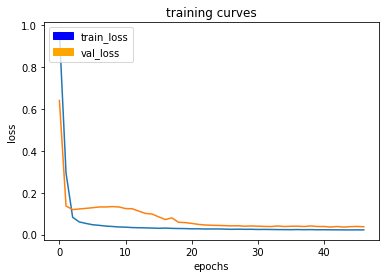

30/30 [==============================] - 93s - loss: 0.0227 - val_loss: 0.0375
Epoch 48/100
29/30 [============================>.] - ETA: 1s - loss: 0.0220

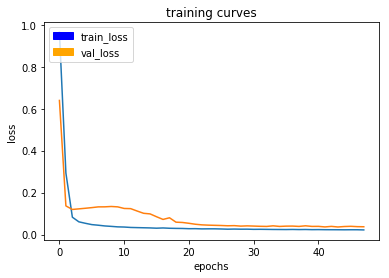

30/30 [==============================] - 92s - loss: 0.0220 - val_loss: 0.0370
Epoch 49/100
29/30 [============================>.] - ETA: 1s - loss: 0.0220

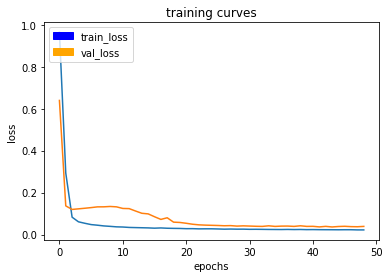

30/30 [==============================] - 91s - loss: 0.0220 - val_loss: 0.0386
Epoch 50/100
29/30 [============================>.] - ETA: 1s - loss: 0.0225

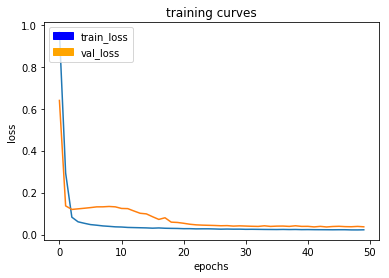

30/30 [==============================] - 94s - loss: 0.0224 - val_loss: 0.0367
Epoch 51/100
29/30 [============================>.] - ETA: 1s - loss: 0.0223

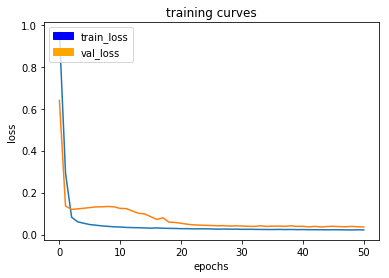

30/30 [==============================] - 93s - loss: 0.0222 - val_loss: 0.0361
Epoch 52/100
29/30 [============================>.] - ETA: 1s - loss: 0.0218

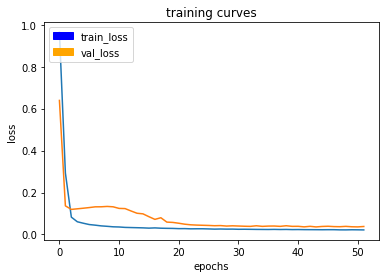

30/30 [==============================] - 94s - loss: 0.0218 - val_loss: 0.0381
Epoch 53/100
29/30 [============================>.] - ETA: 1s - loss: 0.0250

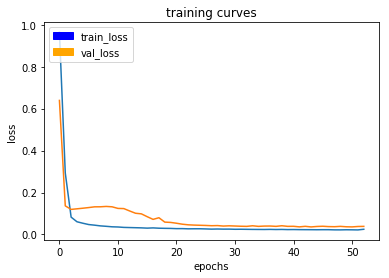

30/30 [==============================] - 92s - loss: 0.0249 - val_loss: 0.0386
Epoch 54/100
29/30 [============================>.] - ETA: 1s - loss: 0.0222

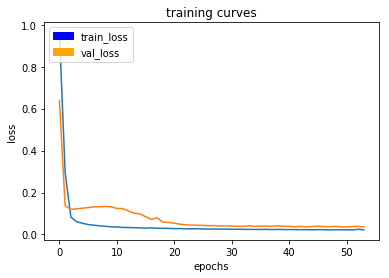

30/30 [==============================] - 93s - loss: 0.0223 - val_loss: 0.0360
Epoch 55/100
29/30 [============================>.] - ETA: 1s - loss: 0.0211

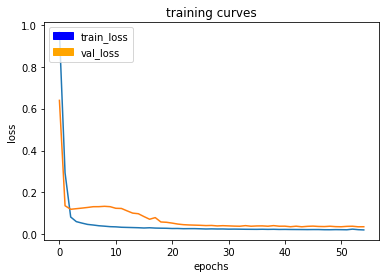

30/30 [==============================] - 95s - loss: 0.0211 - val_loss: 0.0362
Epoch 56/100
29/30 [============================>.] - ETA: 1s - loss: 0.0220

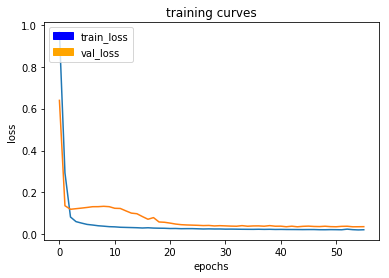

30/30 [==============================] - 95s - loss: 0.0219 - val_loss: 0.0366
Epoch 57/100
29/30 [============================>.] - ETA: 1s - loss: 0.0220

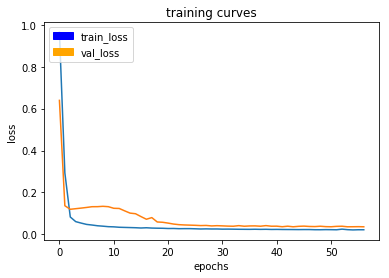

30/30 [==============================] - 92s - loss: 0.0219 - val_loss: 0.0360
Epoch 58/100
29/30 [============================>.] - ETA: 1s - loss: 0.0216

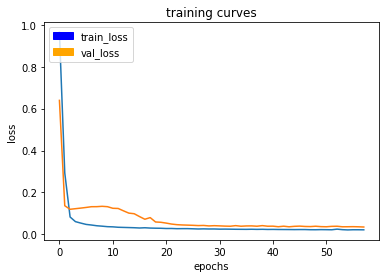

30/30 [==============================] - 92s - loss: 0.0217 - val_loss: 0.0349
Epoch 59/100
29/30 [============================>.] - ETA: 1s - loss: 0.0211

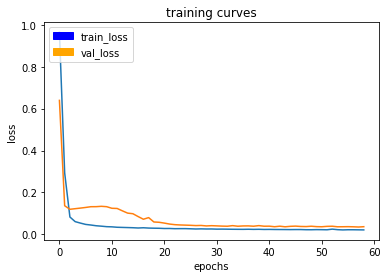

30/30 [==============================] - 92s - loss: 0.0211 - val_loss: 0.0364
Epoch 60/100
29/30 [============================>.] - ETA: 1s - loss: 0.0212

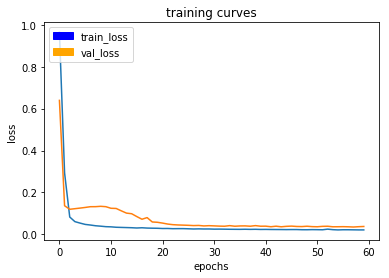

30/30 [==============================] - 94s - loss: 0.0211 - val_loss: 0.0374
Epoch 61/100
29/30 [============================>.] - ETA: 1s - loss: 0.0212

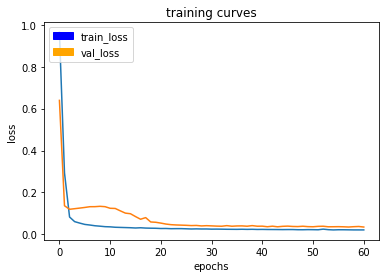

30/30 [==============================] - 94s - loss: 0.0211 - val_loss: 0.0348
Epoch 62/100
29/30 [============================>.] - ETA: 1s - loss: 0.0209

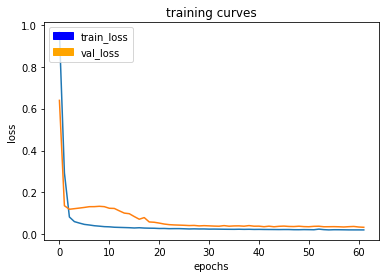

30/30 [==============================] - 93s - loss: 0.0209 - val_loss: 0.0335
Epoch 63/100
29/30 [============================>.] - ETA: 1s - loss: 0.0206

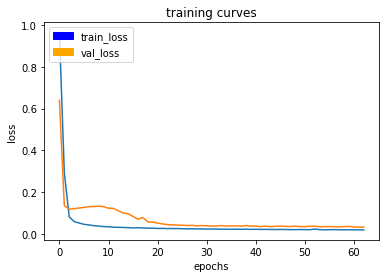

30/30 [==============================] - 93s - loss: 0.0206 - val_loss: 0.0343
Epoch 64/100
29/30 [============================>.] - ETA: 1s - loss: 0.0211

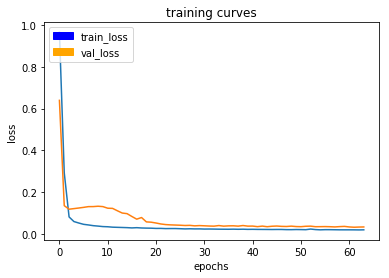

30/30 [==============================] - 96s - loss: 0.0211 - val_loss: 0.0348
Epoch 65/100
29/30 [============================>.] - ETA: 1s - loss: 0.0205

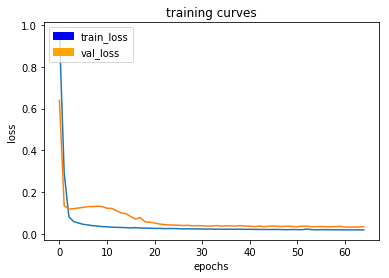

30/30 [==============================] - 93s - loss: 0.0206 - val_loss: 0.0357
Epoch 66/100
29/30 [============================>.] - ETA: 1s - loss: 0.0202

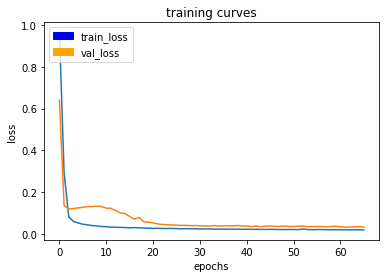

30/30 [==============================] - 90s - loss: 0.0202 - val_loss: 0.0343
Epoch 67/100
29/30 [============================>.] - ETA: 1s - loss: 0.0200

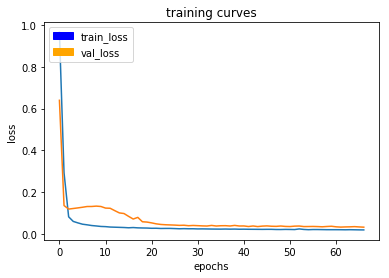

30/30 [==============================] - 93s - loss: 0.0200 - val_loss: 0.0331
Epoch 68/100
29/30 [============================>.] - ETA: 1s - loss: 0.0202

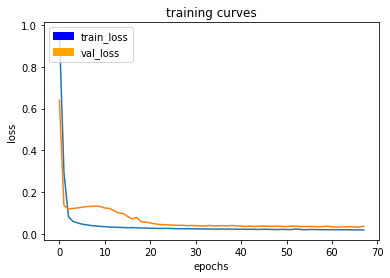

30/30 [==============================] - 93s - loss: 0.0202 - val_loss: 0.0373
Epoch 69/100
29/30 [============================>.] - ETA: 1s - loss: 0.0220

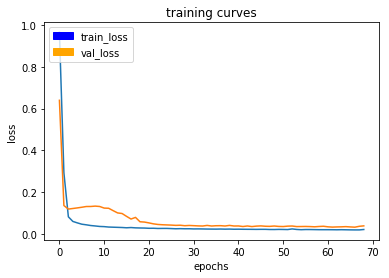

30/30 [==============================] - 93s - loss: 0.0220 - val_loss: 0.0393
Epoch 70/100
29/30 [============================>.] - ETA: 1s - loss: 0.0210

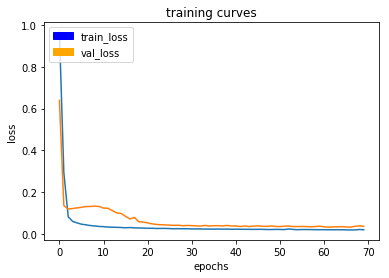

30/30 [==============================] - 92s - loss: 0.0210 - val_loss: 0.0368
Epoch 71/100
29/30 [============================>.] - ETA: 1s - loss: 0.0209

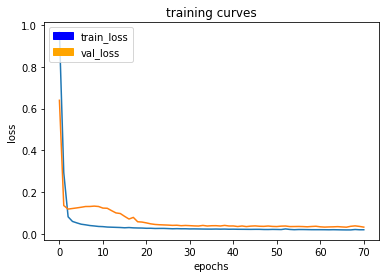

30/30 [==============================] - 93s - loss: 0.0208 - val_loss: 0.0333
Epoch 72/100
29/30 [============================>.] - ETA: 1s - loss: 0.0201

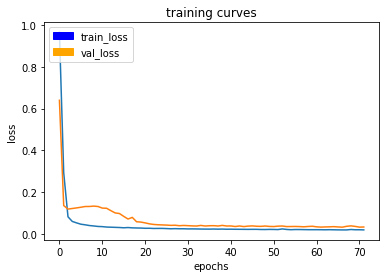

30/30 [==============================] - 92s - loss: 0.0200 - val_loss: 0.0339
Epoch 73/100
29/30 [============================>.] - ETA: 1s - loss: 0.0201

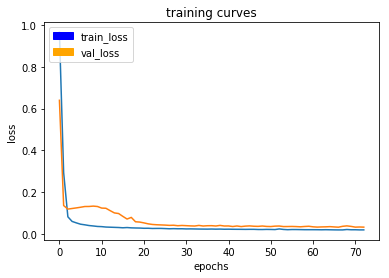

30/30 [==============================] - 94s - loss: 0.0201 - val_loss: 0.0332
Epoch 74/100
29/30 [============================>.] - ETA: 1s - loss: 0.0197

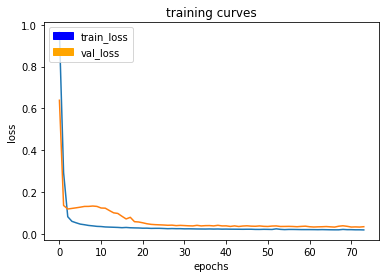

30/30 [==============================] - 94s - loss: 0.0196 - val_loss: 0.0349
Epoch 75/100
29/30 [============================>.] - ETA: 1s - loss: 0.0197

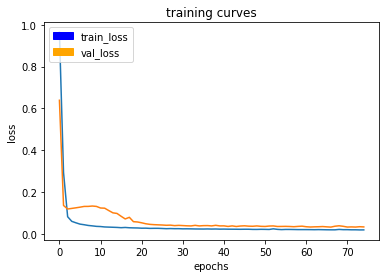

30/30 [==============================] - 94s - loss: 0.0197 - val_loss: 0.0339
Epoch 76/100
29/30 [============================>.] - ETA: 1s - loss: 0.0203

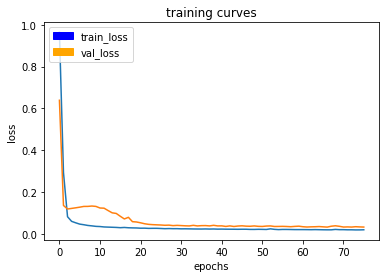

30/30 [==============================] - 93s - loss: 0.0202 - val_loss: 0.0332
Epoch 77/100
29/30 [============================>.] - ETA: 1s - loss: 0.0202

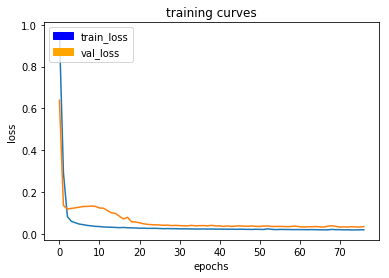

30/30 [==============================] - 94s - loss: 0.0201 - val_loss: 0.0355
Epoch 78/100
29/30 [============================>.] - ETA: 1s - loss: 0.0199

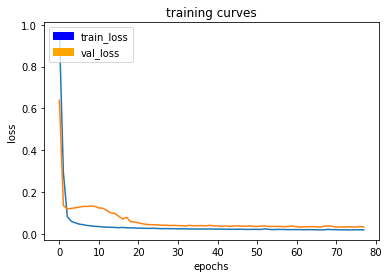

30/30 [==============================] - 92s - loss: 0.0199 - val_loss: 0.0338
Epoch 79/100
29/30 [============================>.] - ETA: 1s - loss: 0.0196

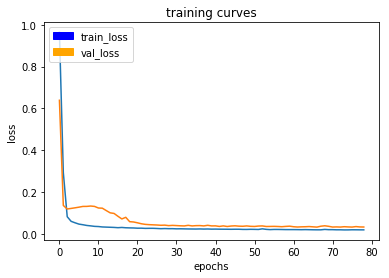

30/30 [==============================] - 92s - loss: 0.0198 - val_loss: 0.0334
Epoch 80/100
29/30 [============================>.] - ETA: 1s - loss: 0.0193

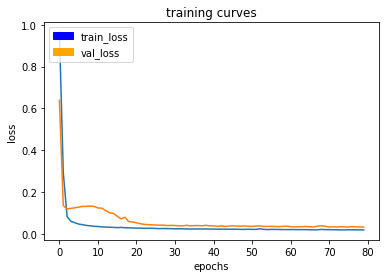

30/30 [==============================] - 95s - loss: 0.0194 - val_loss: 0.0329
Epoch 81/100
29/30 [============================>.] - ETA: 1s - loss: 0.0196

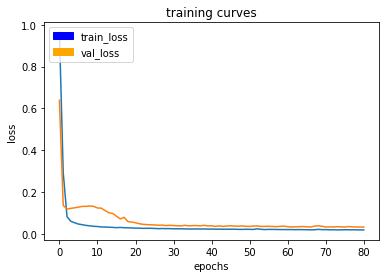

30/30 [==============================] - 93s - loss: 0.0195 - val_loss: 0.0333
Epoch 82/100
29/30 [============================>.] - ETA: 1s - loss: 0.0196

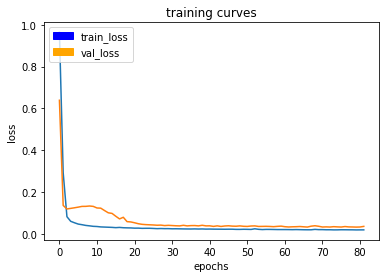

30/30 [==============================] - 94s - loss: 0.0196 - val_loss: 0.0362
Epoch 83/100
29/30 [============================>.] - ETA: 1s - loss: 0.0198

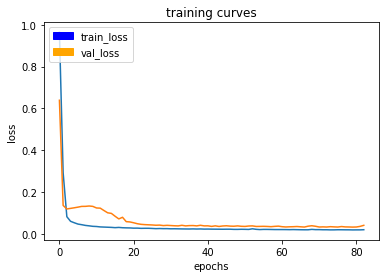

30/30 [==============================] - 93s - loss: 0.0202 - val_loss: 0.0413
Epoch 84/100
29/30 [============================>.] - ETA: 1s - loss: 0.0197

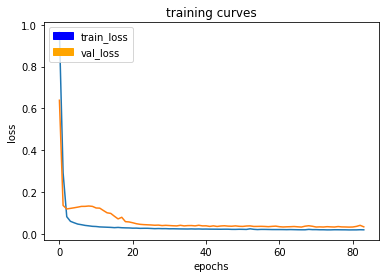

30/30 [==============================] - 94s - loss: 0.0199 - val_loss: 0.0341
Epoch 85/100
29/30 [============================>.] - ETA: 1s - loss: 0.0196

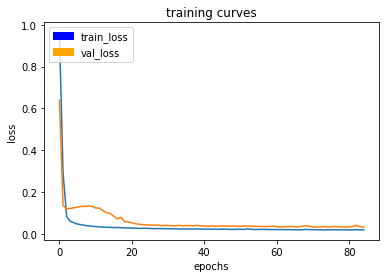

30/30 [==============================] - 93s - loss: 0.0196 - val_loss: 0.0329
Epoch 86/100
29/30 [============================>.] - ETA: 1s - loss: 0.0195

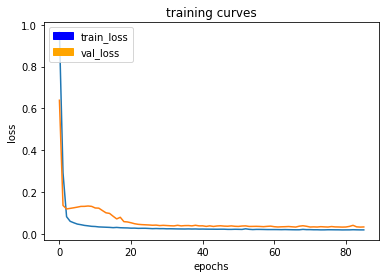

30/30 [==============================] - 94s - loss: 0.0195 - val_loss: 0.0336
Epoch 87/100
29/30 [============================>.] - ETA: 1s - loss: 0.0194

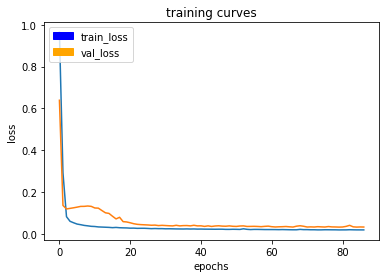

30/30 [==============================] - 92s - loss: 0.0195 - val_loss: 0.0332
Epoch 88/100
29/30 [============================>.] - ETA: 1s - loss: 0.0193

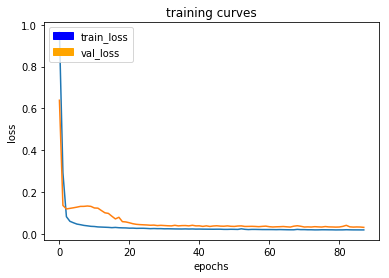

30/30 [==============================] - 95s - loss: 0.0194 - val_loss: 0.0316
Epoch 89/100
29/30 [============================>.] - ETA: 1s - loss: 0.0188

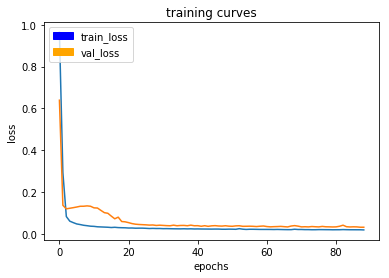

30/30 [==============================] - 92s - loss: 0.0188 - val_loss: 0.0315
Epoch 90/100
29/30 [============================>.] - ETA: 1s - loss: 0.0187

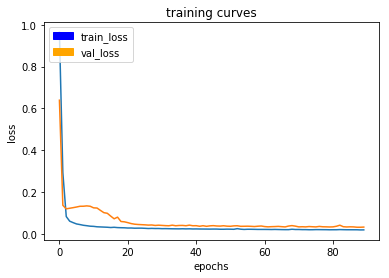

30/30 [==============================] - 95s - loss: 0.0189 - val_loss: 0.0323
Epoch 91/100
29/30 [============================>.] - ETA: 1s - loss: 0.0195

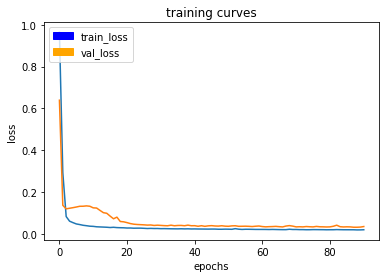

30/30 [==============================] - 92s - loss: 0.0195 - val_loss: 0.0349
Epoch 92/100
29/30 [============================>.] - ETA: 1s - loss: 0.0191

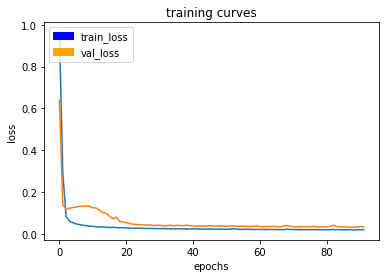

30/30 [==============================] - 93s - loss: 0.0191 - val_loss: 0.0332
Epoch 93/100
29/30 [============================>.] - ETA: 1s - loss: 0.0193

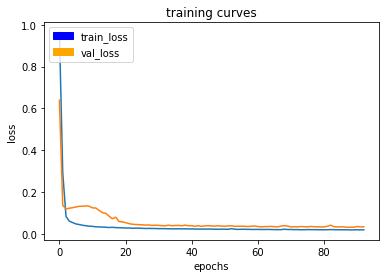

30/30 [==============================] - 94s - loss: 0.0193 - val_loss: 0.0336
Epoch 94/100
29/30 [============================>.] - ETA: 1s - loss: 0.0196

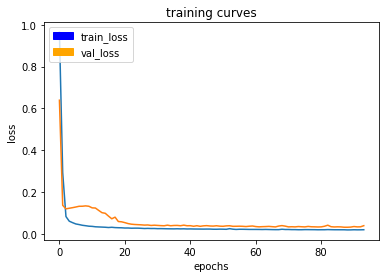

30/30 [==============================] - 94s - loss: 0.0196 - val_loss: 0.0390
Epoch 95/100
29/30 [============================>.] - ETA: 1s - loss: 0.0189

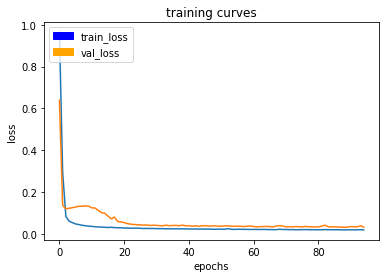

30/30 [==============================] - 94s - loss: 0.0188 - val_loss: 0.0320
Epoch 96/100
29/30 [============================>.] - ETA: 1s - loss: 0.0188

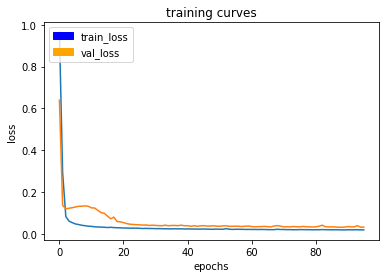

30/30 [==============================] - 92s - loss: 0.0189 - val_loss: 0.0320
Epoch 97/100
29/30 [============================>.] - ETA: 1s - loss: 0.0188

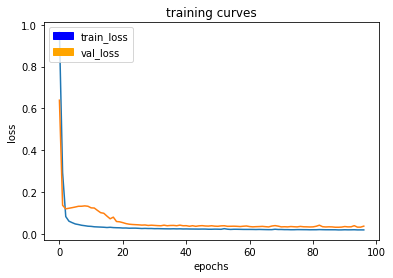

30/30 [==============================] - 96s - loss: 0.0188 - val_loss: 0.0368
Epoch 98/100
29/30 [============================>.] - ETA: 1s - loss: 0.0200

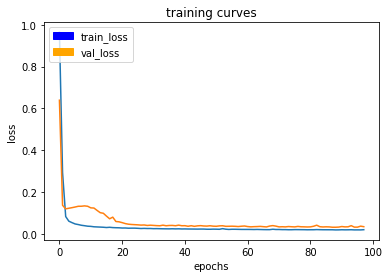

30/30 [==============================] - 94s - loss: 0.0199 - val_loss: 0.0342
Epoch 99/100
29/30 [============================>.] - ETA: 1s - loss: 0.0193

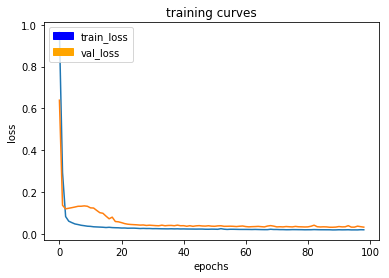

30/30 [==============================] - 93s - loss: 0.0193 - val_loss: 0.0320
Epoch 100/100
29/30 [============================>.] - ETA: 1s - loss: 0.0187

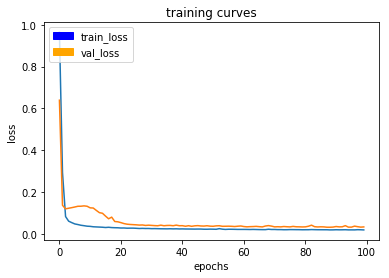

30/30 [==============================] - 94s - loss: 0.0187 - val_loss: 0.0330


In [160]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [164]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction<a id='prediction'></a>

In [143]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [161]:
# generate predictions, save in the runs, directory.
run_number = 'run1'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

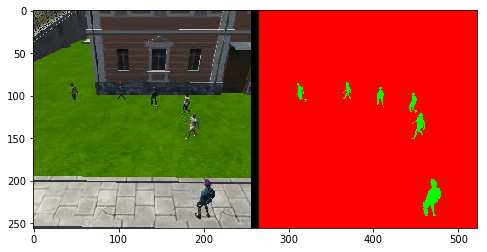

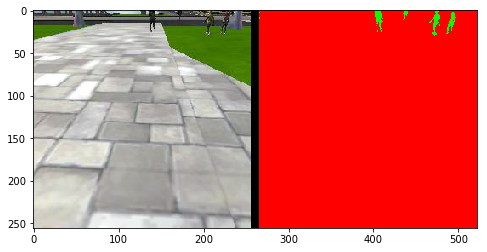

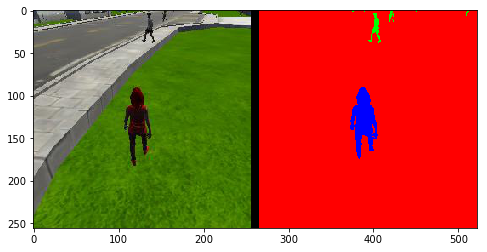

In [162]:
# take a look at predictions
# validation_path = 'validation'
im_files = plotting_tools.get_im_file_sample(run_number,validation_path) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [163]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9923239946027338
average intersection over union for other people is 0.374715224504678
average intersection over union for hero is 0.1439297648896335
global average intersection over union is 0.503656327999015
